In [1]:
import torch
import matplotlib.pyplot as plt
import random

In [2]:
from lstm import LSTM
from ddpm import DDPM, ContextUnet
from grayscott import GrayScott
from training import train_lstm, train_ddpm_on_mnist
from analyzer import Analyzer
from constants import *

In [3]:
def create_sine_dataset(samples=100, seq_len=50):
    data = []
    for _ in range(samples):
        # Random frequency and phase to make it robust
        freq = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        t = np.linspace(0, 10, seq_len)
        
        # Signal = Sine + slight noise
        signal = np.sin(freq * t + phase) + 0.05 * np.random.randn(seq_len)
        data.append(signal)
    
    # Shape: [Batch, Seq_Len, Input_Size=1]
    return torch.FloatTensor(np.array(data)).unsqueeze(2)

def create_shapes_dataset(samples=100, size=32):
    data = []
    for _ in range(samples):
        img = np.zeros((size, size))
        
        # Random Square
        x = np.random.randint(5, size-10)
        y = np.random.randint(5, size-10)
        w = np.random.randint(5, 10)
        img[x:x+w, y:y+w] = 1.0
        
        data.append(img)
        
    # Shape: [Batch, Channels=1, Height, Width]
    return torch.FloatTensor(np.array(data)).unsqueeze(1)

In [4]:
samples = create_sine_dataset(1000,50)
samples.size()

torch.Size([1000, 50, 1])

In [5]:
samples_shape = create_shapes_dataset(100,32)
samples_shape.size()

torch.Size([100, 1, 32, 32])

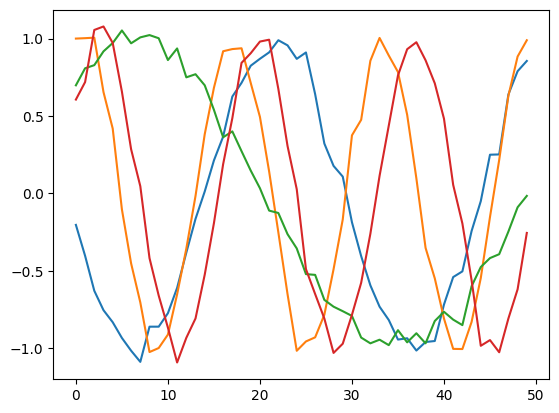

In [6]:
for _ in range(4):
    rand_index = random.randint(0, 100)
    plt.plot(samples[rand_index,:,0])

--- Training LSTM ---
Epoch 0: Loss 0.52785


Text(0.5, 0, 'epoch')

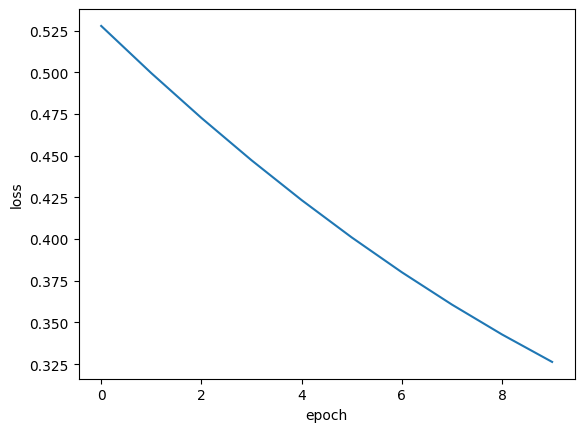

In [7]:
# 1. Create Data
lstm_data = create_sine_dataset(samples=100, seq_len=50)

# 2. Train
lstm_model = LSTM(input_size=1, hidden_size=16)
loss = train_lstm(lstm_model, lstm_data, epochs=10)

plt.plot(loss)
plt.ylabel("loss")
plt.xlabel("epoch")

In [8]:
# Use the first sample from our dataset as a "seed"
seed_sample = lstm_data[0, :, :] # Shape [1, 50, 1]

future_steps = 50
generated = lstm_model.generate_sequence(seed_sample, future_steps=future_steps)

print(f"Seed shape: {seed_sample.shape}")
print(f"Seed values: {seed_sample[:5]}")
print(f"Generated shape: {generated.shape}")
print(f"Generated values: {generated[:5]}")

Seed shape: torch.Size([50, 1])
Seed values: tensor([[0.9939],
        [1.0300],
        [1.0423],
        [0.8813],
        [0.9524]])
Generated shape: torch.Size([50, 1])
Generated values: tensor([[0.2296],
        [0.2062],
        [0.1979],
        [0.1564],
        [0.1152]])


In [13]:
lstm_data[rand_index]


tensor([[-0.2672],
        [-0.4939],
        [-0.7870],
        [-0.9965],
        [-0.8664],
        [-0.8278],
        [-0.5217],
        [-0.2233],
        [ 0.0088],
        [ 0.4642],
        [ 0.6910],
        [ 0.9216],
        [ 1.0299],
        [ 0.9994],
        [ 0.7682],
        [ 0.3673],
        [ 0.1568],
        [-0.2638],
        [-0.6504],
        [-0.8946],
        [-0.9878],
        [-1.1305],
        [-0.8455],
        [-0.6128],
        [-0.2918],
        [ 0.1289],
        [ 0.4906],
        [ 0.7459],
        [ 0.9884],
        [ 1.0039],
        [ 0.9047],
        [ 0.6678],
        [ 0.3597],
        [ 0.0873],
        [-0.3172],
        [-0.6980],
        [-0.7946],
        [-0.9521],
        [-1.0267],
        [-0.8105],
        [-0.5246],
        [-0.1589],
        [ 0.0776],
        [ 0.4422],
        [ 0.7164],
        [ 0.8933],
        [ 0.9535],
        [ 0.8893],
        [ 0.6961],
        [ 0.4029]])

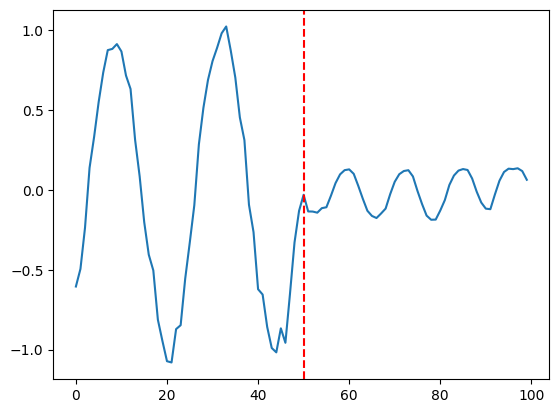

In [32]:
rand_index = random.randint(0, 100)
seed_sample = lstm_data[rand_index]
future_steps = 50
generated_ = lstm_model.generate_sequence(seed_sample, future_steps=future_steps)

plt.plot(torch.cat((seed_sample, generated_)))
plt.axvline(x=50, color='red', linestyle='--')

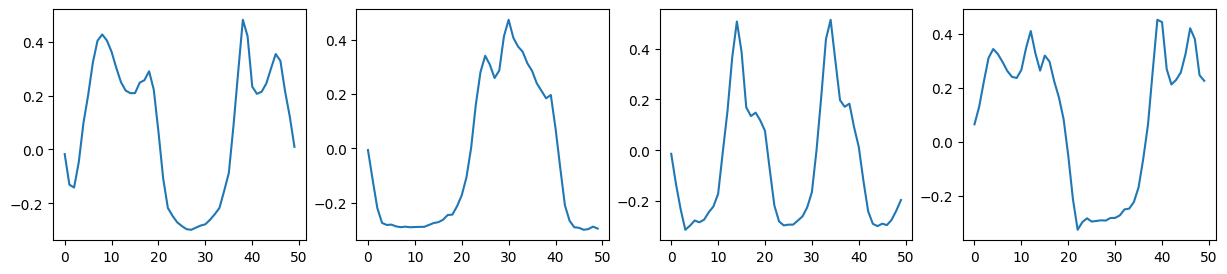

In [35]:
lstm_out, history = lstm_model(lstm_data)
fig, ax = plt.subplots(1,4, figsize=(15,3))
for i in range(4):
    rand_index = random.randint(0,100)
    ax[i].plot(lstm_out[rand_index,:,0].detach().numpy())
plt.show()

In [57]:
history["forget"]

[tensor([[0.7105, 0.3170, 0.0506,  ..., 0.0738, 0.7697, 0.6899],
         [0.3033, 0.6707, 0.9380,  ..., 0.9125, 0.2464, 0.3228],
         [0.4400, 0.5514, 0.6875,  ..., 0.6638, 0.4196, 0.4465],
         ...,
         [0.4070, 0.5798, 0.7737,  ..., 0.7428, 0.3762, 0.4170],
         [0.4684, 0.5270, 0.6019,  ..., 0.5882, 0.4576, 0.4719],
         [0.5120, 0.4897, 0.4609,  ..., 0.4662, 0.5161, 0.5107]]),
 tensor([[0.2724, 0.5927, 0.0806,  ..., 0.0515, 0.8771, 0.6996],
         [0.5287, 0.7445, 0.9080,  ..., 0.9175, 0.1212, 0.2527],
         [0.4959, 0.5684, 0.7763,  ..., 0.7884, 0.2951, 0.3757],
         ...,
         [0.6238, 0.5086, 0.5095,  ..., 0.5879, 0.3669, 0.4343],
         [0.6202, 0.4250, 0.2834,  ..., 0.3408, 0.5461, 0.5410],
         [0.5313, 0.4650, 0.3341,  ..., 0.3422, 0.5894, 0.5544]]),
 tensor([[0.1219, 0.7941, 0.0701,  ..., 0.0554, 0.8909, 0.6768],
         [0.4819, 0.8597, 0.9065,  ..., 0.8993, 0.1826, 0.2639],
         [0.4629, 0.6779, 0.8871,  ..., 0.9098, 0.1896, 0.

In [62]:
forget = [[t[0, d].item() for t in history["forget"]] for d in range(16)]
len(forget[0])

50

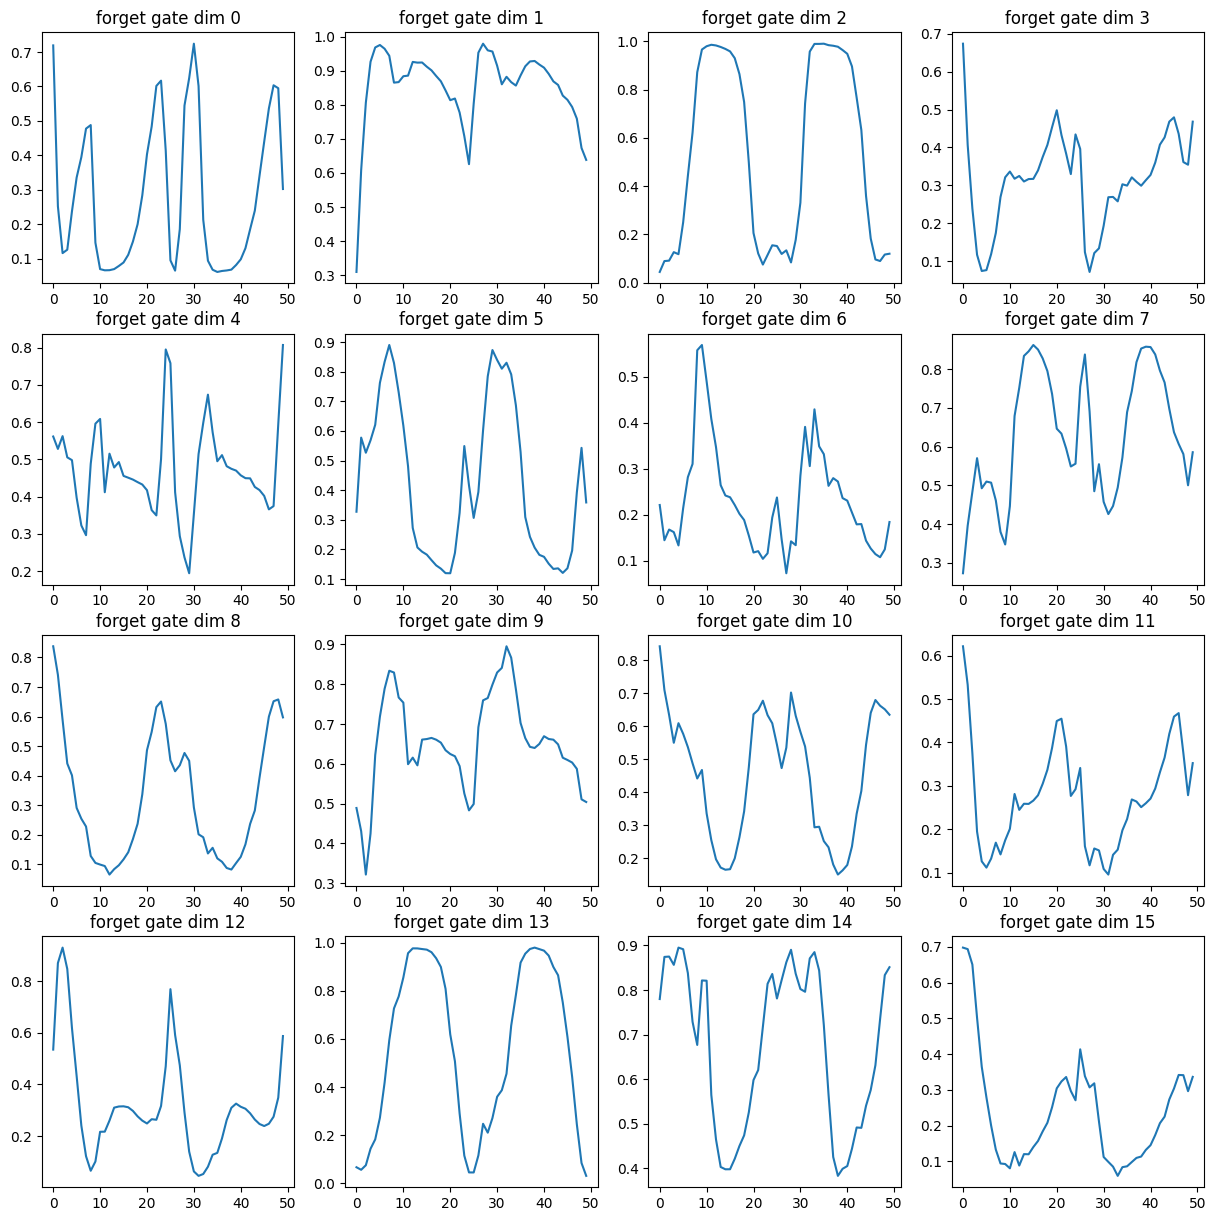

In [70]:
fig, ax = plt.subplots(4,4, figsize=(15,15))

rand_sample = random.randint(0,100)
forget_coef = [[t[rand_sample, d].item() for t in history["forget"]] for d in range(16)]
for i in range(4):
    for j in range(4):
        ax[i,j].plot(forget[4*i+j])
        ax[i,j].set_title(f"forget gate dim {4*i+j}")
plt.show()

In [ ]:
# trained_model = train_ddpm_on_mnist()
# final_img, history = trained_model.sample(n_sample=1, size=(1, 28, 28), device="cpu")

F=0.054, k=0.062: 100%|███████████████████████████████████████▉| 4910/4915 [00:08<00:00, 607.45it/s]
/home/vincentlo/lstm-ddpm/src/analyzer.py:21: RuntimeWarning: invalid value encountered in divide
  corr = corr / corr.max()


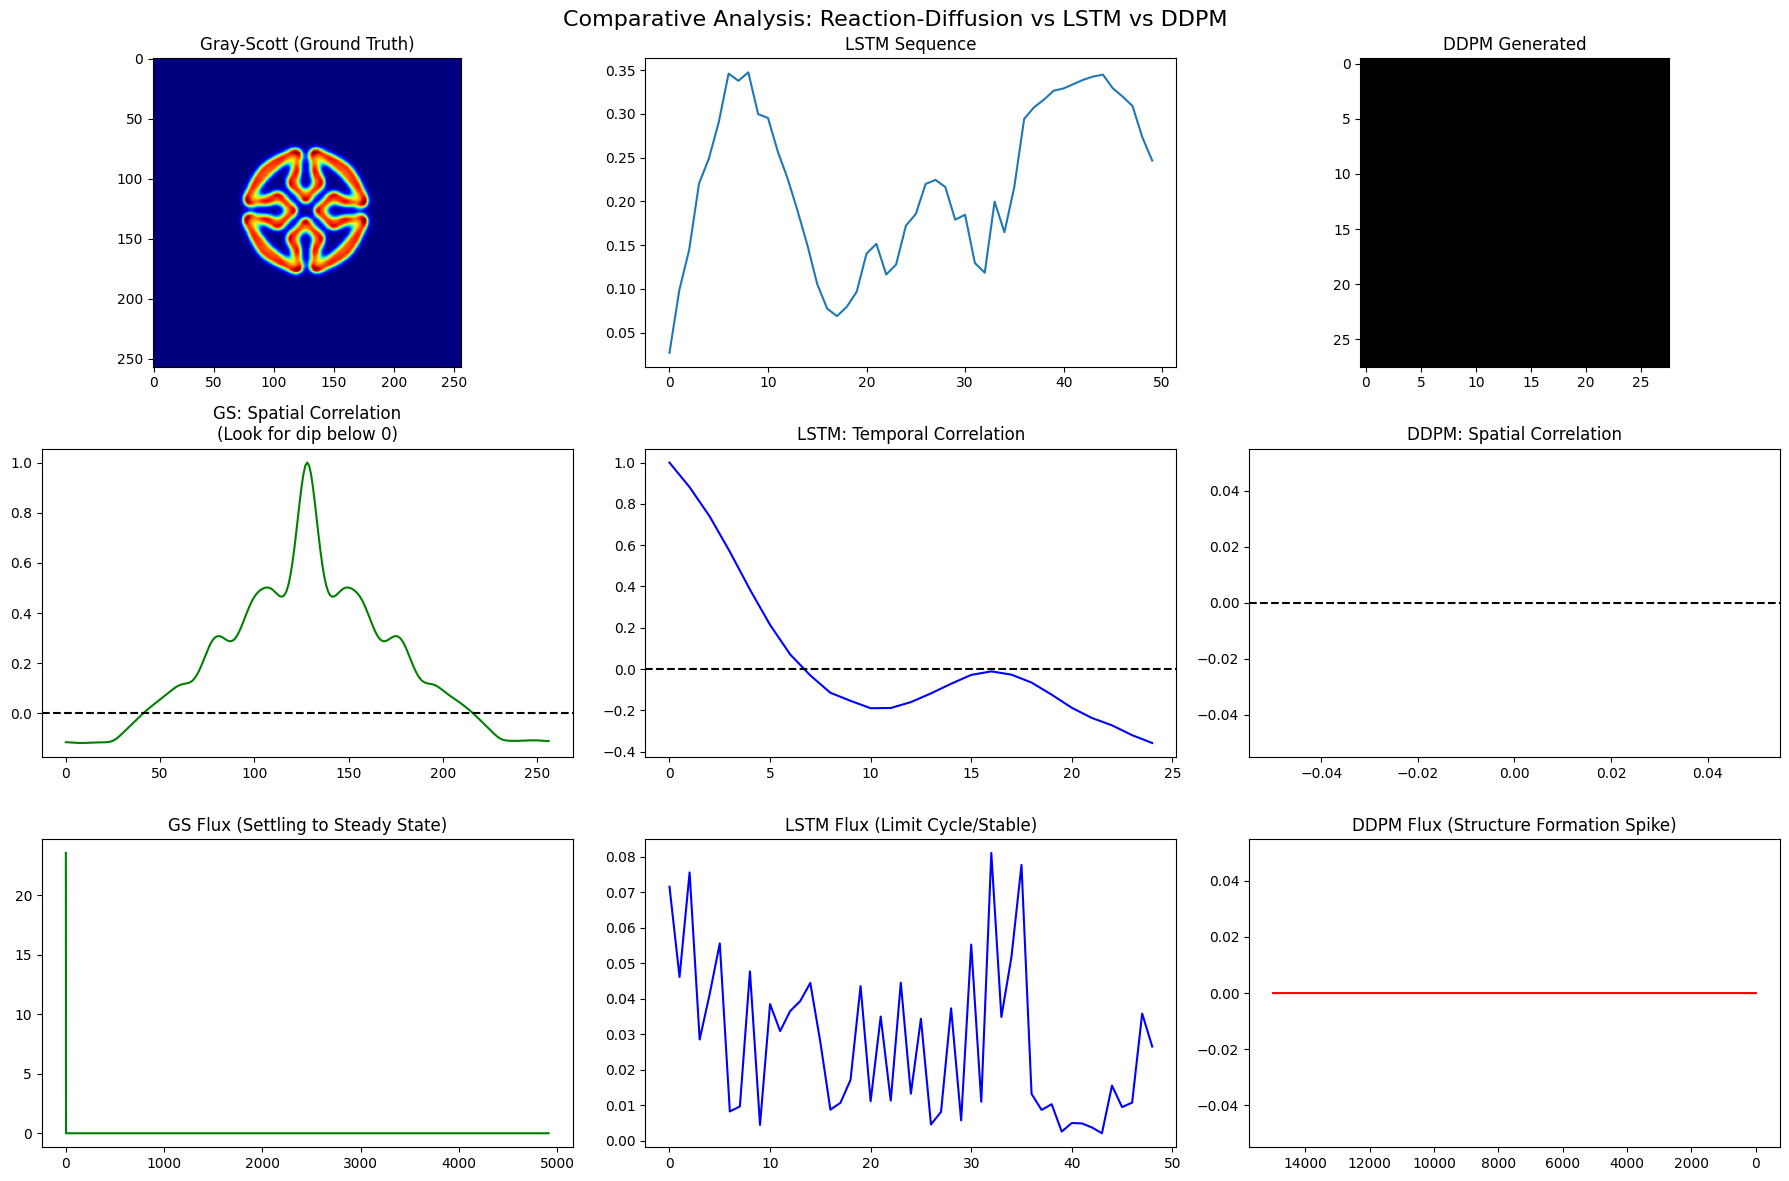

In [72]:
# 1. Get Gray Scott Data
# gs is your GrayScott instance
# gs_history should be a list of frames you saved during the loop
gs = GrayScott(F=F_DEFAULT, k=k_DEFAULT, D_u=Du_DEFAULT, D_v=Dv_DEFAULT, x0=x0, x1=x1, N=N)
_, V_final, V_history, _, _ = gs.forward(0, 3000, frame=False, data=False)
gs_final = V_final[1:-1, 1:-1]
gs_history = np.array(V_history) # Shape: [Time, H, W]

# 2. Get LSTM Data
# output is the predicted sequence [Batch, Seq, 1]
lstm = LSTM()
lstm_output, _ = lstm.forward(lstm_data)
lstm_final = lstm_output[0, :, 0].detach().cpu().numpy()
lstm_history = lstm_output[0, :, :].detach().cpu().numpy() # Treat sequence as history

# 3. Get DDPM Data
# final_img is [1, 28, 28]
# history is list of arrays [Time, 1, 28, 28]
# ddpm_final = ddpm_final_img.squeeze().cpu().numpy()
# ddpm_history = np.array([x.squeeze() for x in ddpm_history_list])
ddpm_final = np.zeros((28,28))
ddpm_history = np.zeros((time_length, 1, 28,28))

# 4. Run Comparison
analyzer = Analyzer()
analyzer.compare_models(gs_final, gs_history, 
                        lstm_final, lstm_history, 
                        ddpm_final, ddpm_history)